In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras import backend as K
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    'Training_data/',
    target_size=(224,224),
    batch_size= 16,
    class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(
    'Test_data/',
    target_size = (224,224),
    batch_size = 1,
    class_mode = 'categorical')

Found 516 images belonging to 7 classes.
Found 47 images belonging to 7 classes.


In [2]:
def VGGModel():
    model = tf.keras.models.Sequential([
    tf.keras.layers.ZeroPadding2D(padding=(1, 1), input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)),
    
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)),
    
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)),
    
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
    ])
    return model

In [3]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = VGGModel()
    model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9),
              metrics=['accuracy'])
    history = model.fit(
          train_generator, 
          steps_per_epoch=32,
          epochs=60,
          verbose=1,
          validation_data = validation_generator,
          validation_steps=47)
    K.set_value(model.optimizer.learning_rate, 0.0001)
    history2 = model.fit(
          train_generator, 
          steps_per_epoch=32,
          epochs=10,
          verbose=1,
          validation_data = validation_generator,
          validation_steps=47)
    model.save('VGGwithValdiation')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Epoch 1/60
INFO:tensorflow:batch_all_reduce: 32 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 32 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast t

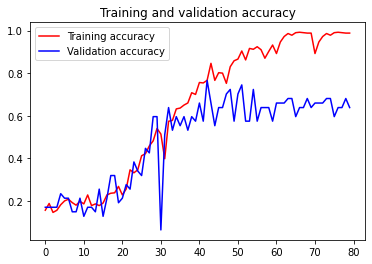

<Figure size 432x288 with 0 Axes>

In [8]:
acc = history.history['accuracy']
acc.extend(history2.history['accuracy'])
val_acc = history.history['val_accuracy']
val_acc.extend(history2.history['val_accuracy'])
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()